# Setup

## Imports

In [201]:
import pandas as pd
import numpy as np
import itertools
import psycopg2 as ps

import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# import joblib

# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer

import os

## Definições

In [202]:
PATH_IGNORE = 'ignore'
PATH_DATA = 'data'

FILE_DATA = os.path.join(PATH_DATA, 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx')
FILE_OLD_DATA = os.path.join(PATH_DATA, 'PEDE_PASSOS_DATASET_FIAP_ANTIGO.xlsx')

file_name = 'data_treated'

FILE_TREATED_DATA = os.path.join(PATH_DATA, f'{file_name}.csv')
FILE_TREATED_DATA2022 = os.path.join(PATH_DATA, f'{file_name}_2022.csv')
FILE_TREATED_DATA2023 = os.path.join(PATH_DATA, f'{file_name}_2023.csv')
FILE_TREATED_DATA2024 = os.path.join(PATH_DATA, f'{file_name}_2024.csv')
FILE_TREATED_DATA_LONG = os.path.join(PATH_DATA, f'{file_name}_long.csv')

FILE_POSTGRES_PW = os.path.join(PATH_IGNORE, 'postgres-pw.txt')

In [203]:
raw_data = {}

raw_data[2022] = pd.read_excel(FILE_DATA, sheet_name=0)
raw_data[2023] = pd.read_excel(FILE_DATA, sheet_name=1)
raw_data[2024] = pd.read_excel(FILE_DATA, sheet_name=2)

# Dicionário

**INDE** - Índice de desenvolvimento educacional
- Ponderação entre os indicadores abaixo

**IAN** - Indicador de adequação de nível
- Registros administrativos
- Registra a defasagem da aprendizagem do aluno por meio da comparação da Fase atual do aluno da Associação, com a equivalência das Fases de ensino na Associação e a divisão dos anos escolares do ensino formal (por idade)
- Utiliza a fase atual, e a fase ideal conforme a idade.
- 10 (em fase), 5 (moderada) ou 2,5 (severa).

**IDA** - Indicador de desempenho acadêmico
- Notas Provas PM e Média geral Universitária
- Registra a proficiência do aluno nos exames padronizados de avaliação interna das disciplinas oferecidas pela Associação (os alunos das Fases 0 a 7). No caso dos alunos da Fase 8, esse indicador registra a nota média obtida pelos alunos em todas as disciplinas curriculares cursadas, nas respectivas instituições de ensino superior conveniadas ao programa de bolsas de estudo da Associação.
- Utiliza as notas internas da associação. Matemática + Português + Inglês / 3
- 0 a 10

**IEG** - Indicador de engajamento
- Registros de entrega de lição de casa e de voluntariado
- Mede o engajamento do aluno nas tarefas curriculares requeridas em cada uma das disciplinas oferecidas na Associação, e/ou seu engajamento em ações de voluntariado desenvolvidas pela Associação.
- Soma das pontuações das tarefas realizadas e registradas / Número de tarefas

**IAA** - Indicador de Autoavaliação
- Questionário de Autoavaliação individual
- Registra por meio de um questionário padronizado e adaptado às distintas faixas etárias dos alunoa a Associação, uma autoavaliação do aluno sobre como se sente consigo mesmo, sobre os estudos, sobre sua família, amigos e comunidade, e e sobre como se sente a respeito da Associação Passos Mágicos.
- Soma das pontuações das respostas do estudante / Número total de perguntas

**IPS** - Indicador Psicossocial
- Questionário individual de avaliação das psicólogas
- Avaliação da equipe de psicólogas para caracterizar o desenvolvimento do aluno nas suas interações familiares, no seu desenvolvimento emocional, comportamental e da sua socialização na vida comunitária. Esse indicador também caracteriza o tipo de atendimento psicológico oferecido pela Associação ao aluno.
- Avaliações feitas por **psicólogos**.
- Soma das pontuações / Número de avaliadores

**IPP** - Indicador Psicopedagógico
- Questionário individual de avaliação dos pedagogos e professores
- Avaliação da equipe de educadores e psicopedagogos para caracterizar o desenvolvimento cognitivo, emocional, comportamental e de socialização do aluno no seu processo de aprendizado dentro do Programa de Aceleração do Conhecimento, dos Programas Educacionais e das Atividades Culturais promovidas pela Associação.
- Soma das avaliações sobre aspectos **pedagógicos** / Número de avaliações

**IPV** - Indicador de Ponto de Virada
- Questionário Individual de avaliação dos pedagogos e professores
- Avaliação da equipe de educadores e psicopedagogos a respeito do desenvolvimento do aluno das aptidões necessárias para iniciar a transformação da sua vida por meio da Educação, avaliando a integração do aluno à Associação, o seu desenvolvimento emocional, e o seu potencial acadêmico.
- Análises longitudinais de progresso acadêmico, engajamento e desenvolvimento emocional

**Pedras** - Baseadas no INDE; limites variam por ano

**Fases** - Baseadas no ano escolar equivalente
- Alfa: 1º e 2º ano (alfabetização) | 7 - 8 anos
- Fase 1: 3º e 4º ano | 8 - 9 anos 
- Fase 2: 5º e 6º ano | 10 - 11 anos
- Fase 3: 7º e 8º ano | 12 - 13 anos
- Fase 4: 9º ano | 14 anos
- Fase 5: 1º EM | 15 anos
- Fase 6: 2º EM | 16 anos
- Fase 7: 3º EM | 17 anos
- Fase 8: Universidade | >= 18 anos

# Tratando dados
## Padronizando colunas
As colunas são inconsistente entre os datasets. Vamos extrair os dados que queremos um por um, ano por ano.

In [204]:
dfs_yearly = {}

dfs_yearly[2022] = pd.DataFrame()
dfs_yearly[2023] = pd.DataFrame()
dfs_yearly[2024] = pd.DataFrame()

In [205]:
def display_column_from_all(
	col : str,
	head : int = 3
):
	for df in dfs_yearly.values():
		display(df[col].head(head))

In [206]:
def display_value_counts_from_all(
	col : str
):
	for df in dfs_yearly.values():
		print(df[col].value_counts())

In [207]:
def replace_value_with(
	df,
	col,
	value,
	replace_with : float | int | bool | str = np.nan
):
	to_na = df[col] == value # mask
	df.loc[to_na, col] = replace_with    

In [208]:
def extract_data(
	col_name : str,
	col_2022 : str,
	col_2023 : str,
	col_2024 : str
):
	# 2022
	year = 2022
	try:
		dfs_yearly[year][col_name] = raw_data[year][col_2022]
	except Exception as e:
		print(f'Failed to find column on {year} | {e}')
		dfs_yearly[year][col_name] = np.nan

	# 2023
	year = 2023
	try:
		dfs_yearly[year][col_name] = raw_data[year][col_2023]
	except Exception as e:
		print(f'Failed to find column on {year} | {e}')
		dfs_yearly[year][col_name] = np.nan

	# 2024
	year = 2024
	try:
		dfs_yearly[year][col_name] = raw_data[year][col_2024]
	except Exception as e:
		print(f'Failed to find column on {year} | {e}')
		dfs_yearly[year][col_name] = np.nan

In [209]:
def process_text(
	df,
	col
):
	try:
		df[col] = df[col].str.capitalize()
	except Exception as e:
		print(f'Failed to process text on df[{col}] | {e}')

In [210]:
def process_text_on_all_years(
		col
):
	for year in dfs_yearly:
		df = dfs_yearly[year]
		process_text(df, col)

In [211]:
def get_column_across_years(col):
	return [f'{col}-{year}' for year in dfs_yearly]

### Alunos

In [212]:
col = 'aluno'

extract_data(
	col,
	'Nome',
	'Nome Anonimizado',
	'Nome Anonimizado'
)

In [213]:
display_column_from_all(col)

0    Aluno-1
1    Aluno-2
2    Aluno-3
Name: aluno, dtype: object

0    Aluno-861
1    Aluno-862
2    Aluno-863
Name: aluno, dtype: object

0    Aluno-1275
1    Aluno-1276
2    Aluno-1277
Name: aluno, dtype: object

### Idade

In [214]:
col = 'idade'

extract_data(
	col,
	'Idade 22',
	'Idade',
	'Idade'
)

In [215]:
display_column_from_all(col)
display_value_counts_from_all(col)

0    19
1    17
2    17
Name: idade, dtype: int64

0    8
1    9
2    7
Name: idade, dtype: object

0    8
1    8
2    8
Name: idade, dtype: int64

idade
10    116
12    107
11    102
13    100
9      96
14     85
15     63
8      57
16     52
17     48
7      14
18     12
19      5
20      2
21      1
Name: count, dtype: int64
idade
11                     77
10                     77
13                     65
9                      65
12                     62
1900-01-11 00:00:00    56
8                      55
14                     54
1900-01-12 00:00:00    47
1900-01-09 00:00:00    43
15                     43
1900-01-14 00:00:00    42
1900-01-10 00:00:00    36
16                     36
1900-01-08 00:00:00    34
1900-01-13 00:00:00    30
17                     25
1900-01-15 00:00:00    22
1900-01-17 00:00:00    21
1900-01-16 00:00:00    19
18                     18
1900-01-07 00:00:00    14
7                      13
1900-01-18 00:00:00    11
1900-01-19 00:00:00    10
1900-01-20 00:00:00    10
19                      8
21                      6
20                      5
22                      4
1900-01-21 00:00:00     3
1900-0

In [216]:
is_int = pd.Series()


count = 0

for row in dfs_yearly[2023][col]:
	is_int[count] = str(type(row)) == "<class 'int'>"
	count += 1

is_int.index = dfs_yearly[2023].index

In [217]:
dfs_yearly[2023].loc[is_int == False, 'idade'] = pd.to_datetime(dfs_yearly[2023].loc[is_int == False, 'idade']).dt.day
dfs_yearly[2023].loc[is_int == False, 'idade']

3        8
5        7
7        7
12      11
15       8
        ..
1000    17
1005    18
1006    21
1011    18
1013    18
Name: idade, Length: 399, dtype: object

In [218]:
dfs_yearly[2023]['idade'] = dfs_yearly[2023]['idade'].astype(int)

In [219]:
display_column_from_all(col)
display_value_counts_from_all(col)

0    19
1    17
2    17
Name: idade, dtype: int64

0    8
1    9
2    7
Name: idade, dtype: int64

0    8
1    8
2    8
Name: idade, dtype: int64

idade
10    116
12    107
11    102
13    100
9      96
14     85
15     63
8      57
16     52
17     48
7      14
18     12
19      5
20      2
21      1
Name: count, dtype: int64
idade
11    133
10    113
12    109
9     108
14     96
13     95
8      89
15     65
16     55
17     46
18     29
7      27
19     18
20     15
21      9
22      4
26      1
23      1
24      1
Name: count, dtype: int64
idade
12    148
11    132
10    128
13    103
9     102
15     98
14     97
16     80
8      68
17     59
18     26
21     25
7      20
19     20
20     20
22     17
23      9
24      2
27      1
25      1
Name: count, dtype: int64


### Ano

In [220]:
col = 'ano'

year = 2022
dfs_yearly[year][col] = year

year = 2023
dfs_yearly[year][col] = year

year = 2024
dfs_yearly[year][col] = year

### Ano de nascimento

In [221]:
col = 'ano_nascimento'

extract_data(
	col,
	col_2022 = 'Ano nasc',
	col_2023 = 'Data de Nasc',
	col_2024 = 'Data de Nasc'
)

In [222]:
display_column_from_all(col)

0    2003
1    2005
2    2005
Name: ano_nascimento, dtype: int64

0    6/17/2015
1    5/31/2014
2    2/25/2016
Name: ano_nascimento, dtype: object

0   2016-07-28
1   2016-10-16
2   2016-08-16
Name: ano_nascimento, dtype: datetime64[ns]

In [223]:
dfs_yearly[2022][col] = dfs_yearly[2022][col].astype('int32')

In [224]:
dfs_yearly[2023][col] = pd.to_datetime(dfs_yearly[2023][col])
dfs_yearly[2023][col] = dfs_yearly[2023][col].dt.year

In [225]:
dfs_yearly[2024][col] = dfs_yearly[2024][col].dt.year

In [226]:
display_column_from_all(col)

0    2003
1    2005
2    2005
Name: ano_nascimento, dtype: int32

0    2015
1    2014
2    2016
Name: ano_nascimento, dtype: int32

0    2016
1    2016
2    2016
Name: ano_nascimento, dtype: int32

### INDE

In [227]:
col = 'inde'

extract_data(
	col,
	col_2022 = 'INDE 22',
	col_2023 = 'INDE 2023',
	col_2024 = 'INDE 2024'
)

display_column_from_all('inde')

0    5.783
1    7.055
2    6.591
Name: inde, dtype: float64

0    9.31095
1    8.22120
2    5.92975
Name: inde, dtype: float64

0    7.611367
1    8.002867
2      7.9522
Name: inde, dtype: object

In [228]:
dfs_yearly[2024][col].describe()

count        1092
unique       1055
top       INCLUIR
freq           38
Name: inde, dtype: object

In [229]:
dfs_yearly[2024][col].value_counts()

inde
INCLUIR     38
8.002867     1
7.9522       1
7.156367     1
5.4442       1
            ..
4.78185      1
7.785233     1
8.27555      1
8.0853       1
7.611367     1
Name: count, Length: 1055, dtype: int64

In [230]:
replace_value_with(
	dfs_yearly[2024],
	col,
	'INCLUIR',
	np.nan
)

In [231]:
dfs_yearly[2024][col] = dfs_yearly[2024][col].astype(float)

In [232]:
display_column_from_all(col)

0    5.783
1    7.055
2    6.591
Name: inde, dtype: float64

0    9.31095
1    8.22120
2    5.92975
Name: inde, dtype: float64

0    7.611367
1    8.002867
2    7.952200
Name: inde, dtype: float64

### Fase

In [233]:
col = 'fase'

extract_data(
	col,
	col_2022 = 'Fase',
	col_2023 = 'Fase',
	col_2024 = 'Fase'
)

for year in dfs_yearly:
	dfs_yearly[year][col] = dfs_yearly[year][col].astype(str)

process_text_on_all_years(col)
display_column_from_all(col)
display_value_counts_from_all(col)

0    7
1    7
2    7
Name: fase, dtype: object

0    Alfa
1    Alfa
2    Alfa
Name: fase, dtype: object

0    Alfa
1    Alfa
2    Alfa
Name: fase, dtype: object

fase
1    192
0    190
2    155
3    148
4     76
5     60
7     21
6     18
Name: count, dtype: int64
fase
Alfa      231
Fase 2    200
Fase 1    173
Fase 3    132
Fase 4     94
Fase 5     65
Fase 8     63
Fase 6     33
Fase 7     23
Name: count, dtype: int64
fase
Alfa    196
9        38
7e       25
8e       23
4m       18
       ... 
2c        8
5g        6
4r        6
4h        4
8a        2
Name: count, Length: 72, dtype: int64


In [234]:
replace_value_with(dfs_yearly[2023], col, 'Alfa', '0')
replace_value_with(dfs_yearly[2024], col, 'Alfa', '0')

##### Extraindo número

In [235]:
dfs_yearly[2023][col].str.extract(r'([0-9])').value_counts()

0
0    231
2    200
1    173
3    132
4     94
5     65
8     63
6     33
7     23
Name: count, dtype: int64

In [236]:
dfs_yearly[2024][col].str.extract(r'([0-9])').value_counts()

0
3    211
0    196
1    185
2    185
4    115
5    100
8     64
9     38
7     37
6     25
Name: count, dtype: int64

In [237]:
dfs_yearly[2022][col] = dfs_yearly[2022][col].astype(int)
dfs_yearly[2023][col] = dfs_yearly[2023][col].str.extract(r'([0-9])').astype(int)
dfs_yearly[2024][col] = dfs_yearly[2024][col].str.extract(r'([0-9])').astype(int)

In [238]:
display_column_from_all(col)
display_value_counts_from_all(col)

0    7
1    7
2    7
Name: fase, dtype: int64

0    0
1    0
2    0
Name: fase, dtype: int64

0    0
1    0
2    0
Name: fase, dtype: int64

fase
1    192
0    190
2    155
3    148
4     76
5     60
7     21
6     18
Name: count, dtype: int64
fase
0    231
2    200
1    173
3    132
4     94
5     65
8     63
6     33
7     23
Name: count, dtype: int64
fase
3    211
0    196
1    185
2    185
4    115
5    100
8     64
9     38
7     37
6     25
Name: count, dtype: int64


### Pedra

In [239]:
col = 'pedra'

extract_data(
	col,
	col_2022 = 'Pedra 22',
	col_2023 = 'Pedra 2023',
	col_2024 = 'Pedra 2024'
)

process_text_on_all_years(col)
display_column_from_all(col)
display_value_counts_from_all(col)

0     Quartzo
1    Ametista
2       Ágata
Name: pedra, dtype: object

0    Topázio
1    Topázio
2    Quartzo
Name: pedra, dtype: object

0    Ametista
1     Topázio
2    Ametista
Name: pedra, dtype: object

pedra
Ametista    348
Ágata       250
Quartzo     132
Topázio     130
Name: count, dtype: int64
pedra
Ametista    381
Agata       246
Topázio     232
Quartzo      72
Name: count, dtype: int64
pedra
Ametista    391
Topázio     326
Agata       225
Quartzo     112
Incluir      38
Name: count, dtype: int64


In [240]:
for year in dfs_yearly:
	replace_value_with(
		dfs_yearly[year],
		col,
		'Incluir'
	)

	replace_value_with(
		dfs_yearly[year],
		col,
		'Agata',
		'Ágata'
	)

In [241]:
display_value_counts_from_all(
	col
)

pedra
Ametista    348
Ágata       250
Quartzo     132
Topázio     130
Name: count, dtype: int64
pedra
Ametista    381
Ágata       246
Topázio     232
Quartzo      72
Name: count, dtype: int64
pedra
Ametista    391
Topázio     326
Ágata       225
Quartzo     112
Name: count, dtype: int64


### Gênero

In [242]:
col = 'genero'

extract_data(
	col,
	col_2022 = 'Gênero',
	col_2023 = 'Gênero',
	col_2024 = 'Gênero'
)

display_column_from_all(col)
display_value_counts_from_all(col)

0    Menina
1    Menina
2    Menina
Name: genero, dtype: object

0     Feminino
1    Masculino
2    Masculino
Name: genero, dtype: object

0    Masculino
1     Feminino
2    Masculino
Name: genero, dtype: object

genero
Menina    457
Menino    403
Name: count, dtype: int64
genero
Feminino     546
Masculino    468
Name: count, dtype: int64
genero
Feminino     623
Masculino    533
Name: count, dtype: int64


In [243]:
dfs_yearly[2022] = dfs_yearly[2022].replace(
	{
		'Menina':'Feminino',
		'Menino':'Masculino'
	}
)

In [244]:
process_text_on_all_years(col)
display_column_from_all(col)

0    Feminino
1    Feminino
2    Feminino
Name: genero, dtype: object

0     Feminino
1    Masculino
2    Masculino
Name: genero, dtype: object

0    Masculino
1     Feminino
2    Masculino
Name: genero, dtype: object

### Ano de ingresso

In [245]:
col = 'ano_ingresso'

extract_data(
	col,
	col_2022 = 'Ano ingresso',
	col_2023 = 'Ano ingresso',
	col_2024 = 'Ano ingresso'
)

display_column_from_all(col)
display_value_counts_from_all(col)

0    2016
1    2017
2    2016
Name: ano_ingresso, dtype: int64

0    2023
1    2023
2    2023
Name: ano_ingresso, dtype: int64

0    2024
1    2024
2    2024
Name: ano_ingresso, dtype: int64

ano_ingresso
2022    399
2019    139
2021    138
2018     67
2020     48
2017     40
2016     29
Name: count, dtype: int64
ano_ingresso
2023    369
2022    268
2021    137
2019     98
2018     46
2020     40
2017     32
2016     24
Name: count, dtype: int64
ano_ingresso
2024    349
2021    345
2023    248
2022    214
Name: count, dtype: int64


### Instituição de ensino

In [246]:
col = 'instituicao_ensino'

extract_data(
	col,
	col_2022 = 'Instituição de ensino',
	col_2023 = 'Instituição de ensino',
	col_2024 = 'Instituição de ensino'
)

process_text_on_all_years(col)
display_column_from_all(col)
display_value_counts_from_all(col)

0    Escola pública
1      Rede decisão
2      Rede decisão
Name: instituicao_ensino, dtype: object

0    Pública
1    Pública
2    Pública
Name: instituicao_ensino, dtype: object

0    Pública
1    Pública
2    Pública
Name: instituicao_ensino, dtype: object

instituicao_ensino
Escola pública    752
Rede decisão      106
Escola jp ii        2
Name: count, dtype: int64
instituicao_ensino
Pública                                      809
Privada - programa de apadrinhamento         100
Privada *parcerias com bolsa 100%             60
Privada                                       28
Privada - pagamento por *empresa parceira      8
Concluiu o 3º em                               7
Nenhuma das opções acima                       2
Name: count, dtype: int64
instituicao_ensino
Pública                                      913
Privada - programa de apadrinhamento          96
Privada                                       76
Privada *parcerias com bolsa 100%             41
Bolsista universitário *formado (a)           13
Privada - pagamento por *empresa parceira      9
Concluiu o 3º em                               7
Name: count, dtype: int64


In [247]:
dfs_yearly[2022] = dfs_yearly[2022].replace(
	{
		'Escola pública' : 'Pública',
	}
)

In [248]:
process_text_on_all_years(col)
display_column_from_all(col)
display_value_counts_from_all(col)

0         Pública
1    Rede decisão
2    Rede decisão
Name: instituicao_ensino, dtype: object

0    Pública
1    Pública
2    Pública
Name: instituicao_ensino, dtype: object

0    Pública
1    Pública
2    Pública
Name: instituicao_ensino, dtype: object

instituicao_ensino
Pública         752
Rede decisão    106
Escola jp ii      2
Name: count, dtype: int64
instituicao_ensino
Pública                                      809
Privada - programa de apadrinhamento         100
Privada *parcerias com bolsa 100%             60
Privada                                       28
Privada - pagamento por *empresa parceira      8
Concluiu o 3º em                               7
Nenhuma das opções acima                       2
Name: count, dtype: int64
instituicao_ensino
Pública                                      913
Privada - programa de apadrinhamento          96
Privada                                       76
Privada *parcerias com bolsa 100%             41
Bolsista universitário *formado (a)           13
Privada - pagamento por *empresa parceira      9
Concluiu o 3º em                               7
Name: count, dtype: int64


### IAN

In [249]:
col = 'ian'

extract_data(
	col,
	col_2022 = 'IAN',
	col_2023 = 'IAN',
	col_2024 = 'IAN'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0     5.0
1    10.0
2    10.0
Name: ian, dtype: float64

0    10.0
1     5.0
2    10.0
Name: ian, dtype: float64

0    10.0
1    10.0
2    10.0
Name: ian, dtype: float64

### IDA

In [250]:
col = 'ida'

extract_data(
	col,
	col_2022 = 'IDA',
	col_2023 = 'IDA',
	col_2024 = 'IDA'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    4.0
1    6.8
2    5.6
Name: ida, dtype: float64

0    9.6
1    8.9
2    6.3
Name: ida, dtype: float64

0    8.0
1    8.0
2    8.0
Name: ida, dtype: float64

### IEG

In [251]:
col = 'ieg'

extract_data(
	col,
	col_2022 = 'IEG',
	col_2023 = 'IEG',
	col_2024 = 'IEG'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    4.1
1    5.2
2    7.9
Name: ieg, dtype: float64

0    10.0
1     9.1
2     7.6
Name: ieg, dtype: float64

0    8.666667
1    9.333333
2    9.083333
Name: ieg, dtype: float64

### IAA

In [252]:
col = 'iaa'

extract_data(
	col,
	col_2022 = 'IAA',
	col_2023 = 'IAA',
	col_2024 = 'IAA'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    8.3
1    8.8
2    0.0
Name: iaa, dtype: float64

0    9.5
1    8.5
2    0.0
Name: iaa, dtype: float64

0    10.002
1    10.002
2    10.002
Name: iaa, dtype: float64

### IPS

In [253]:
col = 'ips'

extract_data(
	col,
	col_2022 = 'IPS',
	col_2023 = 'IPS',
	col_2024 = 'IPS'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    5.6
1    6.3
2    5.6
Name: ips, dtype: float64

0    8.13
1    8.14
2    3.14
Name: ips, dtype: float64

0    6.26
1    3.76
2    3.76
Name: ips, dtype: float64

### IPP

In [254]:
col = 'ipp'

extract_data(
	col,
	col_2022 = 'IPP',
	col_2023 = 'IPP',
	col_2024 = 'IPP'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

Failed to find column on 2022 | 'IPP'


0   NaN
1   NaN
2   NaN
Name: ipp, dtype: float64

0    8.4375
1    7.5000
2    5.9375
Name: ipp, dtype: float64

0    5.625
1    7.500
2    7.500
Name: ipp, dtype: float64

### IPV

In [255]:
col = 'ipv'

extract_data(
	col,
	col_2022 = 'IPV',
	col_2023 = 'IPV',
	col_2024 = 'IPV'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    7.278
1    6.778
2    7.556
Name: ipv, dtype: float64

0    8.920
1    8.585
2    6.260
Name: ipv, dtype: float64

0    5.446667
1    7.050000
2    7.046667
Name: ipv, dtype: float64

In [256]:
year = 2023

select = dfs_yearly[year]['ipv'] > 10

dfs_yearly[year].loc[select, 'ipv'] = 10

### Matemática

In [257]:
col = 'nota_mat'

extract_data(
	col,
	col_2022 = 'Matem',
	col_2023 = 'Mat',
	col_2024 = 'Mat'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    2.7
1    6.3
2    5.8
Name: nota_mat, dtype: float64

0    9.8
1    8.5
2    7.0
Name: nota_mat, dtype: float64

0    10.0
1    10.0
2    10.0
Name: nota_mat, dtype: float64

### Português

In [258]:
col = 'nota_port'

extract_data(
	col,
	col_2022 = 'Portug',
	col_2023 = 'Por',
	col_2024 = 'Por'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    3.5
1    4.5
2    4.0
Name: nota_port, dtype: float64

0    9.4
1    9.2
2    5.5
Name: nota_port, dtype: float64

0    6.0
1    6.0
2    6.0
Name: nota_port, dtype: float64

### Inglês

In [259]:
col = 'nota_ing'

extract_data(
	col,
	col_2022 = 'Inglês',
	col_2023 = 'Ing',
	col_2024 = 'Ing'
)

# process_text_on_all_years(col)
display_column_from_all(col)
# display_value_counts_from_all(col)

0    6.0
1    9.7
2    6.9
Name: nota_ing, dtype: float64

0   NaN
1   NaN
2   NaN
Name: nota_ing, dtype: float64

0   NaN
1   NaN
2   NaN
Name: nota_ing, dtype: float64

## Mergendo dados (wide table)

In [260]:
for year in dfs_yearly:
	dfs_yearly[year] = dfs_yearly[year].set_index('aluno')
dfs_yearly[2022]

,idade,ano,ano_nascimento,inde,fase,pedra,genero,ano_ingresso,instituicao_ensino,ian,ida,ieg,iaa,ips,ipp,ipv,nota_mat,nota_port,nota_ing
aluno,,,,,,,,,,,,,,,,,,,
Aluno-1,19,2022,2003,5.783,7,Quartzo,Feminino,2016,Pública,5.0,4.0,4.1,8.3,5.6,NaN,7.278,2.7,3.5,6.0
Aluno-2,17,2022,2005,7.055,7,Ametista,Feminino,2017,Rede decisão,10.0,6.8,5.2,8.8,6.3,NaN,6.778,6.3,4.5,9.7
Aluno-3,17,2022,2005,6.591,7,Ágata,Feminino,2016,Rede decisão,10.0,5.6,7.9,0.0,5.6,NaN,7.556,5.8,4.0,6.9
Aluno-4,17,2022,2005,5.951,7,Quartzo,Masculino,2017,Rede decisão,10.0,5.0,4.5,8.8,5.6,NaN,5.278,2.8,3.5,8.7
Aluno-5,17,2022,2005,7.427,7,Ametista,Feminino,2016,Rede decisão,10.0,5.2,8.6,7.9,5.6,NaN,7.389,7.0,2.9,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aluno-856,7,2022,2015,8.398,0,Topázio,Masculino,2022,Pública,10.0,8.4,9.1,10.0,7.5,NaN,8.000,8.5,8.2,NaN
Aluno-857,9,2022,2013,8.154,0,Topázio,Feminino,2022,Pública,5.0,9.5,8.9,8.5,7.5,NaN,9.083,9.6,9.3,NaN
Aluno-858,7,2022,2015,7.523,0,Ametista,Masculino,2022,Pública,10.0,7.7,7.1,10.0,5.6,NaN,7.333,8.4,6.9,NaN


### Lidando com dados anuais

In [261]:
data : dict[int, pd.DataFrame] = {}
data[2022] = dfs_yearly[2022].copy()
data[2023] = dfs_yearly[2023].copy()
data[2024] = dfs_yearly[2024].copy()

for year in data:
	data[year].columns = [f'{col}-{year}' for col in data[year].columns]

data[2022].head(3)

,idade-2022,ano-2022,ano_nascimento-2022,inde-2022,fase-2022,pedra-2022,genero-2022,ano_ingresso-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,ips-2022,ipp-2022,ipv-2022,nota_mat-2022,nota_port-2022,nota_ing-2022
aluno,,,,,,,,,,,,,,,,,,,
Aluno-1,19,2022,2003,5.783,7,Quartzo,Feminino,2016,Pública,5.0,4.0,4.1,8.3,5.6,NaN,7.278,2.7,3.5,6.0
Aluno-2,17,2022,2005,7.055,7,Ametista,Feminino,2017,Rede decisão,10.0,6.8,5.2,8.8,6.3,NaN,6.778,6.3,4.5,9.7
Aluno-3,17,2022,2005,6.591,7,Ágata,Feminino,2016,Rede decisão,10.0,5.6,7.9,0.0,5.6,NaN,7.556,5.8,4.0,6.9


In [262]:
students : dict[int, set] = {}

for year in data:
	students[year] = set(data[year].index)

In [263]:
# Alunos que estão presentes apenas nos registros de 2023 para frente
students[2023] = students[2023] - students[2022]
print(len(students[2023]))

# Alunos que estão presentes apenas nos registros de 2024 para frente
students[2024] = students[2024] - students[2022] - students[2023]
print(len(students[2024]))

414
387


#### Atualizando alunos de 2022 até 2024

In [264]:
df_students_2022 : pd.DataFrame

df_students_2022 = pd.merge(
	left = data[2022],
	right = data[2023],
	on = 'aluno',
	how = 'left'
)

df_students_2022 = pd.merge(
	left = df_students_2022,
	right = data[2024],
	on = 'aluno',
	how = 'left'
)

df_students_2022.head(3)

,idade-2022,ano-2022,ano_nascimento-2022,inde-2022,fase-2022,pedra-2022,genero-2022,ano_ingresso-2022,instituicao_ensino-2022,ian-2022,...,ian-2024,ida-2024,ieg-2024,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19,2022,2003,5.783,7,Quartzo,Feminino,2016,Pública,5.0,...,10.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-2,17,2022,2005,7.055,7,Ametista,Feminino,2017,Rede decisão,10.0,...,10.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-3,17,2022,2005,6.591,7,Ágata,Feminino,2016,Rede decisão,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
df_students_2022.shape, len(students[2022])

((860, 57), 860)

#### Atualizando alunos de 2023 até 2024

In [266]:
df_students_2023 : pd.DataFrame

df_students_2023 = pd.merge(
	left = data[2023].loc[list(students[2023])],
	right = data[2024],
	on = 'aluno',
	how = 'left'
)

df_students_2023.head(3)

,idade-2023,ano-2023,ano_nascimento-2023,inde-2023,fase-2023,pedra-2023,genero-2023,ano_ingresso-2023,instituicao_ensino-2023,ian-2023,...,ian-2024,ida-2024,ieg-2024,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1211,16,2023,2007,7.092050,5,Ametista,Feminino,2023,Pública,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-1041,10,2023,2013,6.724117,1,Ágata,Feminino,2023,Pública,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-1014,7,2023,2016,8.258200,0,Topázio,Feminino,2023,Pública,10.0,...,5.0,5.25,7.886364,8.502,2.51,6.875,7.0,6.5,4.0,NaN


In [267]:
df_students_2023.shape, len(students[2023])

((414, 38), 414)

#### Pegando os alunos de 2024

In [268]:
df_students_2024 : pd.DataFrame

df_students_2024 = data[2024].loc[list(students[2024])]

df_students_2024.head(3)

,idade-2024,ano-2024,ano_nascimento-2024,inde-2024,fase-2024,pedra-2024,genero-2024,ano_ingresso-2024,instituicao_ensino-2024,ian-2024,ida-2024,ieg-2024,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024
aluno,,,,,,,,,,,,,,,,,,,
Aluno-1341,9,2024,2015,7.862906,0,Ametista,Masculino,2024,Pública,5.0,10.00,9.246032,10.002,7.510,5.62500,6.000000,10.0,10.0,NaN
Aluno-1333,9,2024,2015,8.213200,0,Topázio,Masculino,2024,Pública,5.0,9.25,10.000000,7.502,6.255,9.37500,7.750000,10.0,8.5,NaN
Aluno-1572,15,2024,2009,8.080346,4,Topázio,Feminino,2024,Pública,5.0,7.50,9.841270,9.168,7.510,7.65625,8.393333,7.5,6.5,8.5


In [269]:
df_students_2024.shape, len(students[2024])

((387, 19), 387)

### Juntando as sheets

#### Padronizando as colunas

In [270]:
cols = df_students_2022.columns

for df in [df_students_2023, df_students_2024]:
	for col in cols:
		if col not in df.columns:
			df[col] = np.nan

#### Concatenando

In [271]:
df = pd.concat(
	[df_students_2022,
	df_students_2023]
)

df = pd.concat(
	[df,
	 df_students_2024]
)

df.shape

(1661, 57)

In [272]:
len(students[2022] | students[2023] | students[2024])

1661

In [273]:
df.dtypes

idade-2022                 float64
ano-2022                   float64
ano_nascimento-2022        float64
inde-2022                  float64
fase-2022                  float64
pedra-2022                  object
genero-2022                 object
ano_ingresso-2022          float64
instituicao_ensino-2022     object
ian-2022                   float64
ida-2022                   float64
ieg-2022                   float64
iaa-2022                   float64
ips-2022                   float64
ipp-2022                   float64
ipv-2022                   float64
nota_mat-2022              float64
nota_port-2022             float64
nota_ing-2022              float64
idade-2023                 float64
ano-2023                   float64
ano_nascimento-2023        float64
inde-2023                  float64
fase-2023                  float64
pedra-2023                  object
genero-2023                 object
ano_ingresso-2023          float64
instituicao_ensino-2023     object
ian-2023            

## Checando união
Vamos ver se os alunos estão coerentes entre anos

In [274]:
def columns_are_equal(df : pd.DataFrame, col_list : list):
	combinations : list[tuple] = [x for x in itertools.combinations(list(range(len(col_list))), 2)]
	# print(combinations)

	values = df[col_list]

	are_equal = pd.Series()
	count = 0

	for row in values.values:
		values_are_equal = True
		for combination in combinations:
			x = combination[0]
			y = combination[1]
			if row[x] == row[y]:
				pass
			else:
				values_are_equal = False
		
		are_equal[count] = values_are_equal
		count += 1


	are_equal.index = df.index
	return are_equal.all(), are_equal

#### Ano de ingresso

In [275]:
cols = get_column_across_years('ano_ingresso')

df_check = df[cols].dropna()

check, are_equal = columns_are_equal(df_check, cols)
check

np.False_

In [276]:
df_check.loc[are_equal == False, cols].head(10)

,ano_ingresso-2022,ano_ingresso-2023,ano_ingresso-2024
aluno,,,
Aluno-1,2016.0,2016.0,2021.0
Aluno-2,2017.0,2017.0,2021.0
Aluno-7,2017.0,2017.0,2021.0
Aluno-12,2020.0,2020.0,2021.0
Aluno-13,2016.0,2016.0,2021.0
Aluno-27,2016.0,2016.0,2021.0
Aluno-31,2019.0,2019.0,2021.0
Aluno-35,2019.0,2019.0,2021.0
Aluno-36,2019.0,2019.0,2021.0


Futuramente, vamos utilizar o primeiro ano de ingresso disponível por aluno para lidar com essa disparidade

#### Gênero

In [277]:
cols = get_column_across_years('genero')

df_check = df[cols].dropna()

check, are_equal = columns_are_equal(df_check, cols)
check

np.False_

In [278]:
df_check.loc[are_equal == False, cols].head(10)

,genero-2022,genero-2023,genero-2024
aluno,,,
Aluno-62,Masculino,Feminino,Feminino
Aluno-64,Masculino,Feminino,Feminino
Aluno-78,Masculino,Feminino,Feminino
Aluno-534,Feminino,Masculino,Masculino
Aluno-603,Feminino,Masculino,Masculino
Aluno-629,Masculino,Feminino,Feminino
Aluno-719,Feminino,Masculino,Masculino
Aluno-777,Masculino,Feminino,Feminino
Aluno-784,Masculino,Feminino,Feminino


#### Ano de nascimento

In [279]:
cols = get_column_across_years('ano_nascimento')

df_check = df[cols].dropna()

check, are_equal = columns_are_equal(df_check, cols)
check

np.False_

In [280]:
df_check.loc[are_equal == False, cols].head(10)

,ano_nascimento-2022,ano_nascimento-2023,ano_nascimento-2024
aluno,,,
Aluno-27,2005.0,2006.0,2006.0
Aluno-158,2005.0,2009.0,2009.0
Aluno-161,2011.0,2009.0,2009.0
Aluno-178,2009.0,2009.0,2008.0
Aluno-184,2006.0,2010.0,2010.0
Aluno-444,2011.0,2011.0,2009.0
Aluno-454,2008.0,2008.0,2007.0


Vamos checar se as idades estão mais coerentes

In [281]:
df[800:810][get_column_across_years('idade')]


,idade-2022,idade-2023,idade-2024
aluno,,,
Aluno-801,9.0,9.0,10.0
Aluno-802,9.0,10.0,11.0
Aluno-803,10.0,NaN,NaN
Aluno-804,10.0,11.0,NaN
Aluno-805,8.0,9.0,10.0
Aluno-806,8.0,9.0,10.0
Aluno-807,8.0,9.0,10.0
Aluno-808,8.0,9.0,10.0
Aluno-809,7.0,NaN,NaN


Vamos ajustar `ano_nascimento` para condizer com a idade.

In [282]:
for year in dfs_yearly:
	dfs_yearly[year]['ano_nascimento'] = dfs_yearly[year]['ano'] - dfs_yearly[year]['idade']

dfs_yearly[2022].head(3)

,idade,ano,ano_nascimento,inde,fase,pedra,genero,ano_ingresso,instituicao_ensino,ian,ida,ieg,iaa,ips,ipp,ipv,nota_mat,nota_port,nota_ing
aluno,,,,,,,,,,,,,,,,,,,
Aluno-1,19,2022,2003,5.783,7,Quartzo,Feminino,2016,Pública,5.0,4.0,4.1,8.3,5.6,NaN,7.278,2.7,3.5,6.0
Aluno-2,17,2022,2005,7.055,7,Ametista,Feminino,2017,Rede decisão,10.0,6.8,5.2,8.8,6.3,NaN,6.778,6.3,4.5,9.7
Aluno-3,17,2022,2005,6.591,7,Ágata,Feminino,2016,Rede decisão,10.0,5.6,7.9,0.0,5.6,NaN,7.556,5.8,4.0,6.9


In [283]:
for col_age, col_year, col_birth in zip(get_column_across_years('idade'), get_column_across_years('ano'), get_column_across_years('ano_nascimento')):
	df[col_birth] = df[col_year] - df[col_age]
df[get_column_across_years('ano_nascimento')].head()

,ano_nascimento-2022,ano_nascimento-2023,ano_nascimento-2024
aluno,,,
Aluno-1,2003.0,2003.0,2003.0
Aluno-2,2005.0,2005.0,2005.0
Aluno-3,2005.0,NaN,NaN
Aluno-4,2005.0,NaN,NaN
Aluno-5,2005.0,2005.0,NaN


## Dados únicos
Temos dados que não fazem sentidos serem registrados anualmente. Vamos padronizá-los e retirar os desnecessários.

In [284]:
def make_column_with_earliest_information(df : pd.DataFrame, col : str):

	new_col = df[get_column_across_years(col)].copy()

	new_col[col] = new_col[f'{col}-2022']
	missing = new_col[col].isna()

	new_col.loc[missing, col] = new_col[f'{col}-2023']
	missing = new_col[col].isna()

	new_col.loc[missing, col] = new_col[f'{col}-2024']
	missing = new_col[col].isna()

	return new_col[col]

In [285]:
def make_column_with_latest_information(df : pd.DataFrame, col : str):

	new_col = df[get_column_across_years(col)].copy()

	new_col[col] = new_col[f'{col}-2024']
	missing = new_col[col].isna()

	new_col.loc[missing, col] = new_col[f'{col}-2023']
	missing = new_col[col].isna()

	new_col.loc[missing, col] = new_col[f'{col}-2022']
	missing = new_col[col].isna()

	return new_col[col]

In [286]:
new_cols = {}

#### Ano de ingresso

In [288]:
standardized_column = 'ano_ingresso'

new_cols[standardized_column] = make_column_with_earliest_information(df, standardized_column)

display(new_cols[standardized_column].head(5))
new_cols[standardized_column].isna().sum()

aluno
Aluno-1    2016.0
Aluno-2    2017.0
Aluno-3    2016.0
Aluno-4    2017.0
Aluno-5    2016.0
Name: ano_ingresso, dtype: float64

np.int64(0)

In [289]:
for col in get_column_across_years(standardized_column):
	df : pd.DataFrame = df.drop(col, axis = 1)

In [290]:
df[standardized_column] = new_cols[standardized_column].astype(int)
df.head(3)

,idade-2022,ano-2022,ano_nascimento-2022,inde-2022,fase-2022,pedra-2022,genero-2022,instituicao_ensino-2022,ian-2022,ida-2022,...,ida-2024,ieg-2024,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,ano_ingresso
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,2003.0,5.783,7.0,Quartzo,Feminino,Pública,5.0,4.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
Aluno-2,17.0,2022.0,2005.0,7.055,7.0,Ametista,Feminino,Rede decisão,10.0,6.8,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
Aluno-3,17.0,2022.0,2005.0,6.591,7.0,Ágata,Feminino,Rede decisão,10.0,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016


#### Ano de nascimento

In [291]:
standardized_column = 'ano_nascimento'

new_cols[standardized_column] = make_column_with_earliest_information(df, standardized_column)

display(new_cols[standardized_column].head(5))
print(new_cols[standardized_column].isna().sum())

for col in get_column_across_years(standardized_column):
	df = df.drop(col, axis = 1)
	
df[standardized_column] = new_cols[standardized_column].astype(int)
df.head(3)

aluno
Aluno-1    2003.0
Aluno-2    2005.0
Aluno-3    2005.0
Aluno-4    2005.0
Aluno-5    2005.0
Name: ano_nascimento, dtype: float64

0


,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,genero-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,...,ieg-2024,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,ano_ingresso,ano_nascimento
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Feminino,Pública,5.0,4.0,4.1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2003
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Feminino,Rede decisão,10.0,6.8,5.2,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,2005
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Feminino,Rede decisão,10.0,5.6,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2005


#### Gênero

In [292]:
standardized_column = 'genero'

new_cols[standardized_column] = make_column_with_latest_information(df, standardized_column)

display(new_cols[standardized_column].head(5))
print(new_cols[standardized_column].isna().sum())

for col in get_column_across_years(standardized_column):
	df = df.drop(col, axis = 1)
	
df[standardized_column] = new_cols[standardized_column]
df.head(3)

aluno
Aluno-1     Feminino
Aluno-2     Feminino
Aluno-3     Feminino
Aluno-4    Masculino
Aluno-5     Feminino
Name: genero, dtype: object

0


,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,...,iaa-2024,ips-2024,ipp-2024,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,ano_ingresso,ano_nascimento,genero
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,4.0,4.1,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2003,Feminino
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,6.8,5.2,8.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,2005,Feminino
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,5.6,7.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2005,Feminino


In [293]:
df[standardized_column].loc['Aluno-719']

'Masculino'

## Criando dados novos

#### Desistência
Classificaremos como desistente o aluno que para de ter informações na base após um dado ano

In [294]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
idade-2022,860.0,12.138372,2.771998,7.000000,10.000000,12.000000,14.000000,21.000000
ano-2022,860.0,2022.000000,0.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000
inde-2022,860.0,7.036176,1.017773,3.032000,6.485500,7.197000,7.751250,9.442000
fase-2022,860.0,2.098837,1.788789,0.000000,1.000000,2.000000,3.000000,7.000000
ian-2022,860.0,6.424419,2.389609,2.500000,5.000000,5.000000,10.000000,10.000000
ida-2022,860.0,6.092907,2.046209,0.000000,4.800000,6.300000,7.600000,9.900000
ieg-2022,860.0,7.891163,1.638340,0.000000,7.000000,8.300000,9.100000,10.000000
iaa-2022,860.0,8.274419,2.064935,0.000000,7.900000,8.800000,9.500000,10.000000
ips-2022,860.0,6.905000,1.070707,2.500000,6.300000,7.500000,7.500000,10.000000
ipp-2022,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Utilizaremos o índice IAN como referência.

In [295]:
churn_next_year = pd.DataFrame()

reference_col = 'ian'

for col in get_column_across_years(reference_col):
	churn_next_year[col] = df[col].copy()

new_col = 'desistiu'

for col in get_column_across_years(new_col):
	churn_next_year[col] = np.nan

churn_next_year.head(3)

,ian-2022,ian-2023,ian-2024,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,
Aluno-1,5.0,10.0,10.0,NaN,NaN,NaN
Aluno-2,10.0,10.0,10.0,NaN,NaN,NaN
Aluno-3,10.0,NaN,NaN,NaN,NaN,NaN


In [296]:
ian_2022_exists = churn_next_year['ian-2022'].isna() == False # ian de 2022 existe
ian_2023_exists = churn_next_year['ian-2023'].isna() == False # ian de 2023 existe

churn_next_year.loc[ian_2022_exists, f'{new_col}-2022'] = 0
selection = ian_2022_exists & (ian_2023_exists == False) # existe em 2022 mas não em 2023
churn_next_year.loc[selection, f'{new_col}-2022'] = 1

churn_next_year.head()

,ian-2022,ian-2023,ian-2024,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,
Aluno-1,5.0,10.0,10.0,0.0,NaN,NaN
Aluno-2,10.0,10.0,10.0,0.0,NaN,NaN
Aluno-3,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-4,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-5,10.0,10.0,NaN,0.0,NaN,NaN


In [297]:
# !! não queremos incluir os que desistiram em 2022 junto com os que desistiram em 2023

ian_2023_exists = churn_next_year['ian-2023'].isna() == False # ian de 2023 existe
ian_2024_exists = churn_next_year['ian-2024'].isna() == False # ian de 2024 existe

churn_next_year.loc[ian_2023_exists, f'{new_col}-2023'] = 0
selection = ian_2023_exists & (ian_2024_exists == False) # existe em 2023 mas não em 2024
churn_next_year.loc[selection, f'{new_col}-2023'] = 1

churn_next_year.head()

,ian-2022,ian-2023,ian-2024,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,
Aluno-1,5.0,10.0,10.0,0.0,0.0,NaN
Aluno-2,10.0,10.0,10.0,0.0,0.0,NaN
Aluno-3,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-4,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-5,10.0,10.0,NaN,0.0,1.0,NaN


In [298]:
# checando se deu certo
selection = churn_next_year['desistiu-2022'] == True
churn_next_year[selection].head(8)

,ian-2022,ian-2023,ian-2024,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,
Aluno-3,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-4,10.0,NaN,NaN,1.0,NaN,NaN
Aluno-8,5.0,NaN,NaN,1.0,NaN,NaN
Aluno-9,5.0,NaN,NaN,1.0,NaN,NaN
Aluno-10,5.0,NaN,NaN,1.0,NaN,NaN
Aluno-11,5.0,NaN,NaN,1.0,NaN,NaN
Aluno-15,5.0,NaN,NaN,1.0,NaN,NaN
Aluno-16,5.0,NaN,NaN,1.0,NaN,NaN


In [299]:
# checando se deu certo
selection = churn_next_year['desistiu-2023'] == True
churn_next_year[selection].head(8)

,ian-2022,ian-2023,ian-2024,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,
Aluno-5,10.0,10.0,NaN,0.0,1.0,NaN
Aluno-32,10.0,10.0,NaN,0.0,1.0,NaN
Aluno-34,5.0,10.0,NaN,0.0,1.0,NaN
Aluno-43,5.0,5.0,NaN,0.0,1.0,NaN
Aluno-44,5.0,5.0,NaN,0.0,1.0,NaN
Aluno-46,5.0,2.5,NaN,0.0,1.0,NaN
Aluno-53,5.0,5.0,NaN,0.0,1.0,NaN
Aluno-55,5.0,5.0,NaN,0.0,1.0,NaN


In [300]:
for col in get_column_across_years('desistiu'):
	print(churn_next_year[col].value_counts())
	print()

desistiu-2022
0.0    600
1.0    260
Name: count, dtype: int64

desistiu-2023
0.0    765
1.0    249
Name: count, dtype: int64

Series([], Name: count, dtype: int64)



In [301]:
for col in get_column_across_years('desistiu'):
	df[col] = churn_next_year[col]
df.head()

,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,...,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,ano_ingresso,ano_nascimento,genero,desistiu-2022,desistiu-2023,desistiu-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,4.0,4.1,8.3,...,NaN,NaN,NaN,NaN,2016,2003,Feminino,0.0,0.0,NaN
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,6.8,5.2,8.8,...,NaN,NaN,NaN,NaN,2017,2005,Feminino,0.0,0.0,NaN
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,5.6,7.9,0.0,...,NaN,NaN,NaN,NaN,2016,2005,Feminino,1.0,NaN,NaN
Aluno-4,17.0,2022.0,5.951,7.0,Quartzo,Rede decisão,10.0,5.0,4.5,8.8,...,NaN,NaN,NaN,NaN,2017,2005,Masculino,1.0,NaN,NaN
Aluno-5,17.0,2022.0,7.427,7.0,Ametista,Rede decisão,10.0,5.2,8.6,7.9,...,NaN,NaN,NaN,NaN,2016,2005,Feminino,0.0,1.0,NaN


#### Anos com a organização
Há quantos anos o aluno estuda com a Passos Mágicos

In [302]:
years_studied = pd.DataFrame()

years_studied['ano_ingresso'] = df['ano_ingresso']

for yearly_col in get_column_across_years('ano'):
	years_studied[yearly_col] = df[yearly_col]

years_studied.head(3)

,ano_ingresso,ano-2022,ano-2023,ano-2024
aluno,,,,
Aluno-1,2016,2022.0,2023.0,2024.0
Aluno-2,2017,2022.0,2023.0,2024.0
Aluno-3,2016,2022.0,NaN,NaN


In [303]:
new_col = 'anos_estudados'
for col in get_column_across_years(new_col):
	years_studied[col] = np.nan

years_studied.head(3)

,ano_ingresso,ano-2022,ano-2023,ano-2024,anos_estudados-2022,anos_estudados-2023,anos_estudados-2024
aluno,,,,,,,
Aluno-1,2016,2022.0,2023.0,2024.0,NaN,NaN,NaN
Aluno-2,2017,2022.0,2023.0,2024.0,NaN,NaN,NaN
Aluno-3,2016,2022.0,NaN,NaN,NaN,NaN,NaN


In [304]:
for year in dfs_yearly:
	years_studied[f'{new_col}-{year}'] = years_studied[f'ano-{year}'] - years_studied[f'ano_ingresso']

years_studied.head(3)

,ano_ingresso,ano-2022,ano-2023,ano-2024,anos_estudados-2022,anos_estudados-2023,anos_estudados-2024
aluno,,,,,,,
Aluno-1,2016,2022.0,2023.0,2024.0,6.0,7.0,8.0
Aluno-2,2017,2022.0,2023.0,2024.0,5.0,6.0,7.0
Aluno-3,2016,2022.0,NaN,NaN,6.0,NaN,NaN


In [305]:
for col in get_column_across_years('anos_estudados'):
	df[col] = years_studied[col]
df.head()

,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,...,nota_ing-2024,ano_ingresso,ano_nascimento,genero,desistiu-2022,desistiu-2023,desistiu-2024,anos_estudados-2022,anos_estudados-2023,anos_estudados-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,4.0,4.1,8.3,...,NaN,2016,2003,Feminino,0.0,0.0,NaN,6.0,7.0,8.0
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,6.8,5.2,8.8,...,NaN,2017,2005,Feminino,0.0,0.0,NaN,5.0,6.0,7.0
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,5.6,7.9,0.0,...,NaN,2016,2005,Feminino,1.0,NaN,NaN,6.0,NaN,NaN
Aluno-4,17.0,2022.0,5.951,7.0,Quartzo,Rede decisão,10.0,5.0,4.5,8.8,...,NaN,2017,2005,Masculino,1.0,NaN,NaN,5.0,NaN,NaN
Aluno-5,17.0,2022.0,7.427,7.0,Ametista,Rede decisão,10.0,5.2,8.6,7.9,...,NaN,2016,2005,Feminino,0.0,1.0,NaN,6.0,7.0,NaN


#### Defasagem
Booleano de se a defasagem aumentou, e booleano de se a defasagem diminuiu

In [306]:
lag = pd.DataFrame()

reference_col = 'ian'

for col in get_column_across_years('ian'):
	lag[col] = df[col]
	
lag.head(3)

,ian-2022,ian-2023,ian-2024
aluno,,,
Aluno-1,5.0,10.0,10.0
Aluno-2,10.0,10.0,10.0
Aluno-3,10.0,NaN,NaN


A defasagem **aumentar** significa que o **Índice de Adequação de Nível (IAN)** CAIU

In [307]:
new_col = 'defasou'

for col in get_column_across_years(new_col):
	lag[col] = np.nan

lag.head(3)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024
aluno,,,,,,
Aluno-1,5.0,10.0,10.0,NaN,NaN,NaN
Aluno-2,10.0,10.0,10.0,NaN,NaN,NaN
Aluno-3,10.0,NaN,NaN,NaN,NaN,NaN


In [308]:
for year in [2023, 2024]:
	selection_na = lag[f'ian-{year - 1}'].isna() == False # alunos que tem dados no ano anterior para comparar
	selection = lag[f'ian-{year}'] < lag[f'ian-{year - 1}'] # defasou
	selection_inverse = lag[f'ian-{year}'] >= lag[f'ian-{year - 1}']

	lag.loc[selection, f'{new_col}-{year}'] = 1
	lag.loc[selection_inverse, f'{new_col}-{year}'] = 0

lag[selection].head(3)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024
aluno,,,,,,
Aluno-107,5.0,10.0,5.0,NaN,0.0,1.0
Aluno-239,5.0,5.0,2.5,NaN,0.0,1.0
Aluno-304,5.0,5.0,2.5,NaN,0.0,1.0


In [309]:
lag[lag['defasou-2023'] == 1].tail(3)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024
aluno,,,,,,
Aluno-850,10.0,5.0,5.0,NaN,1.0,0.0
Aluno-851,10.0,5.0,5.0,NaN,1.0,0.0
Aluno-853,10.0,5.0,10.0,NaN,1.0,0.0


In [310]:
lag[lag['defasou-2023'].isna()].tail(10)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024
aluno,,,,,,
Aluno-1298,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1282,NaN,NaN,5.0,NaN,NaN,NaN
Aluno-1581,NaN,NaN,5.0,NaN,NaN,NaN
Aluno-1578,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1608,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1657,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1474,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1441,NaN,NaN,10.0,NaN,NaN,NaN
Aluno-1443,NaN,NaN,5.0,NaN,NaN,NaN


A defasagem **diminuir** significa que o **Índice de Adequação de Nível (IAN)** SUBIU

In [311]:
new_col = 'adequou'

for col in get_column_across_years(new_col):
	lag[col] = np.nan

lag.head(3)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024,adequou-2022,adequou-2023,adequou-2024
aluno,,,,,,,,,
Aluno-1,5.0,10.0,10.0,NaN,0.0,0.0,NaN,NaN,NaN
Aluno-2,10.0,10.0,10.0,NaN,0.0,0.0,NaN,NaN,NaN
Aluno-3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [312]:
for year in [2023, 2024]:
	selection_na = lag[f'ian-{year - 1}'].isna() == False # alunos que tem dados no ano anterior para comparar
	selection = lag[f'ian-{year}'] > lag[f'ian-{year - 1}'] # adequou
	selection_inverse = lag[f'ian-{year}'] <= lag[f'ian-{year - 1}']

	lag.loc[selection, f'{new_col}-{year}'] = 1
	lag.loc[selection_inverse, f'{new_col}-{year}'] = 0

lag[selection].head(3)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024,adequou-2022,adequou-2023,adequou-2024
aluno,,,,,,,,,
Aluno-19,5.0,5.0,10.0,NaN,0.0,0.0,NaN,0.0,1.0
Aluno-26,5.0,5.0,10.0,NaN,0.0,0.0,NaN,0.0,1.0
Aluno-40,5.0,5.0,10.0,NaN,0.0,0.0,NaN,0.0,1.0


In [313]:
lag[lag['adequou-2023'] == 1].head(4)

,ian-2022,ian-2023,ian-2024,defasou-2022,defasou-2023,defasou-2024,adequou-2022,adequou-2023,adequou-2024
aluno,,,,,,,,,
Aluno-1,5.0,10.0,10.0,NaN,0.0,0.0,NaN,1.0,0.0
Aluno-6,5.0,10.0,10.0,NaN,0.0,0.0,NaN,1.0,0.0
Aluno-7,5.0,10.0,10.0,NaN,0.0,0.0,NaN,1.0,0.0
Aluno-13,5.0,10.0,10.0,NaN,0.0,0.0,NaN,1.0,0.0


In [314]:
for col in (get_column_across_years('defasou') + get_column_across_years('adequou')):
	df[col] = lag[col]
df.head()

,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,...,desistiu-2024,anos_estudados-2022,anos_estudados-2023,anos_estudados-2024,defasou-2022,defasou-2023,defasou-2024,adequou-2022,adequou-2023,adequou-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,4.0,4.1,8.3,...,NaN,6.0,7.0,8.0,NaN,0.0,0.0,NaN,1.0,0.0
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,6.8,5.2,8.8,...,NaN,5.0,6.0,7.0,NaN,0.0,0.0,NaN,0.0,0.0
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,5.6,7.9,0.0,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-4,17.0,2022.0,5.951,7.0,Quartzo,Rede decisão,10.0,5.0,4.5,8.8,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-5,17.0,2022.0,7.427,7.0,Ametista,Rede decisão,10.0,5.2,8.6,7.9,...,NaN,6.0,7.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


### Defasagem FUTURA
O aluno defasou ou se adequou no ano SEGUINTE

In [315]:
future_lag = pd.DataFrame()

reference_col = 'defasou'
for col in get_column_across_years(reference_col):
	future_lag[col] = df[col]

future_lag['defasará-2022'] = future_lag[f'{reference_col}-2023']
future_lag['defasará-2023'] = future_lag[f'{reference_col}-2024']
future_lag['defasará-2024'] = np.nan


reference_col = 'adequou'
for col in get_column_across_years(reference_col):
	future_lag[col] = df[col]

future_lag['adequará-2022'] = future_lag[f'{reference_col}-2023']
future_lag['adequará-2023'] = future_lag[f'{reference_col}-2024']
future_lag['adequará-2024'] = np.nan
	
future_lag.head(3)

,defasou-2022,defasou-2023,defasou-2024,defasará-2022,defasará-2023,defasará-2024,adequou-2022,adequou-2023,adequou-2024,adequará-2022,adequará-2023,adequará-2024
aluno,,,,,,,,,,,,
Aluno-1,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,0.0,NaN
Aluno-2,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
Aluno-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
for col in (get_column_across_years('defasará') + get_column_across_years('adequará')):
	df[col] = future_lag[col]
df.head()

,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,ida-2022,ieg-2022,iaa-2022,...,defasou-2024,adequou-2022,adequou-2023,adequou-2024,defasará-2022,defasará-2023,defasará-2024,adequará-2022,adequará-2023,adequará-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,4.0,4.1,8.3,...,0.0,NaN,1.0,0.0,0.0,0.0,NaN,1.0,0.0,NaN
Aluno-2,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,6.8,5.2,8.8,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
Aluno-3,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,5.6,7.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-4,17.0,2022.0,5.951,7.0,Quartzo,Rede decisão,10.0,5.0,4.5,8.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aluno-5,17.0,2022.0,7.427,7.0,Ametista,Rede decisão,10.0,5.2,8.6,7.9,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN


### IPP (2022)
Conforme orientado, iremos preencher o IPP faltando do ano 2022.

Temos a fórmula com o qual o INDE foi calculado:

$$INDE = IAN*0.1 + IDA*0.2 + IEG*0.2 + IAA*0.1 + IPS*0.1 + IPP*0.1 + IPV*0.2$$

Para alunos da fase 1-7

In [317]:
df['fase-2022'].value_counts()

fase-2022
1.0    192
0.0    190
2.0    155
3.0    148
4.0     76
5.0     60
7.0     21
6.0     18
Name: count, dtype: int64

2022 não tem alunos na fase 8, então podemos usar a seguinte fórmula para achar o IPP registrado.

$$\frac{(INDE - IAN*0.1 - IDA*0.2 - IEG*0.2 - IAA*0.1 - IPS*0.1 -IPV*0.2)}{0.1} = IPP$$

In [318]:
def calculate_ipp(
		df,
		inde,
		ian,
		ida,
		ieg,
		iaa,
		ips,
		ipv
):
	ipp = (df[inde] - df[ian]*0.1 - df[ida]*0.2 - df[ieg]*0.2 - df[iaa]*0.1 - df[ips]*0.1 - df[ipv]*0.2)/0.1
	return ipp

In [319]:
def calculate_ian(
		df,
		inde,
		ida,
		ieg,
		iaa,
		ips,
		ipp,
		ipv
):
	ian = (df[inde]- df[ida]*0.2 - df[ieg]*0.2 - df[iaa]*0.1 - df[ips]*0.1 - df[ipp]*0.1 - df[ipv]*0.2)/0.1
	return ian

In [320]:
def calculate_ida(
		df,
		inde,
		ian,
		ieg,
		iaa,
		ips,
		ipp,
		ipv
):
	ida = (df[inde]- df[ian]*0.1 - df[ieg]*0.2 - df[iaa]*0.1 - df[ips]*0.1 - df[ipp]*0.1 - df[ipv]*0.2)/0.2
	return ida

In [321]:
def calculate_ieg(
		df,
		inde,
		ian,
		ida,
		iaa,
		ips,
		ipp,
		ipv
):
	ieg = (df[inde]- df[ian]*0.1 - df[ida]*0.2 - df[iaa]*0.1 - df[ips]*0.1 - df[ipp]*0.1 - df[ipv]*0.2)/0.2
	return ieg

In [322]:
def calculate_iaa(
		df,
		inde,
		ian,
		ida,
		ieg,
		ips,
		ipp,
		ipv
):
	iaa = (df[inde]- df[ian]*0.1 - df[ida]*0.2 - df[ieg]*0.2 - df[ips]*0.1 - df[ipp]*0.1 - df[ipv]*0.2)/0.1
	return iaa

In [323]:
def calculate_ips(
		df,
		inde,
		ian,
		ida,
		ieg,
		iaa,
		ipp,
		ipv
):
	ips = (df[inde]- df[ian]*0.1 - df[ida]*0.2 - df[ieg]*0.2 - df[iaa]*0.1 - df[ipp]*0.1 - df[ipv]*0.2)/0.1
	return ips

In [324]:
def calculate_ips(
		df,
		inde,
		ian,
		ida,
		ieg,
		iaa,
		ipp,
		ips
):
	ipv = (df[inde]- df[ian]*0.1 - df[ida]*0.2 - df[ieg]*0.2 - df[iaa]*0.1 - df[ipp]*0.1 - df[ips]*0.1)/0.2
	return ipv

In [325]:
# def calculate_indicator(
# 	indicators = {
# 		'inde': None,
# 		'ian': None,
# 		'ida': None,
# 		'ieg': None,
# 		'iaa': None,
# 		'ips': None,
# 		'ipp': None,
# 		'ipv': None
# 	},
# 	phase = 0
# 	):
# 	all_indicators = {
# 		'inde': None,
# 		'ian': None,
# 		'ida': None,
# 		'ieg': None,
# 		'iaa': None,
# 		'ips': None,
# 		'ipp': None,
# 		'ipv': None
# 	}
# 	none_count = 0
# 	for ind in indicators:
# 		if indicators[ind] == None:
# 			none_count += 1
# 		else:
# 			all_indicators[ind] = indicators[ind]
	
# 	if none_count > 1:
# 		return
# 	else:
		

In [326]:
year = 2022

ipp_2022 = round(calculate_ipp(
	df,
	f'inde-{year}',
	f'ian-{year}',
	f'ida-{year}',
	f'ieg-{year}',
	f'iaa-{year}',
	f'ips-{year}',
	f'ipv-{year}'
), 2)

In [327]:
ipp_2022.describe()

count    860.000000
mean       6.282419
std        1.133258
min       -0.070000
25%        5.607500
50%        6.140000
75%        7.030000
max        9.120000
dtype: float64

In [328]:
(ipp_2022 < 0).value_counts()

False    1660
True        1
Name: count, dtype: int64

Vamos arredondar os número negativo para 0.

In [329]:
selection = ipp_2022 < 0

ipp_2022[selection] = 0

In [330]:
df['ipp-2022'] = ipp_2022

In [331]:
df.describe()['ipp-2022']

count    860.000000
mean       6.282500
std        1.132804
min        0.000000
25%        5.607500
50%        6.140000
75%        7.030000
max        9.120000
Name: ipp-2022, dtype: float64

## Ajustando a ordem das colunas


In [332]:
def get_columns_from_year(
		target_year : int,
		include_non_yearly : bool = True
		):
	target_year_string = f'{target_year}'
	year_cols = []

	for col in df.columns:
		elements = col.split('-')
		if len(elements) < 2:
			if include_non_yearly:
				year_cols.append(col)
		else:
			if elements[1] == target_year_string:
				year_cols.append(col)
			else:
				pass

	return year_cols

In [333]:
def get_non_yearly_columns(df : pd.DataFrame):
	fixed_cols = []

	for col in df.columns:
		elements = col.split('-')
		if len(elements) < 2:
			fixed_cols.append(col)
		else:
			pass

	return fixed_cols    

In [334]:
def get_yearly_columns_prefix(df : pd.DataFrame):
	yearly_columns = []
	for col in df.columns:
		elements = col.split('-')
		if len(elements) > 1:
			if elements[0] not in yearly_columns:
				yearly_columns.append(elements[0])
		else:
			pass
	return yearly_columns

In [335]:
def get_column_across_years(col):
	return [f'{col}-{year}' for year in dfs_yearly]

---

In [336]:
new_order = get_non_yearly_columns(df)

for year in dfs_yearly:
	new_order += get_columns_from_year(year, False)

new_order

['ano_ingresso',
 'ano_nascimento',
 'genero',
 'idade-2022',
 'ano-2022',
 'inde-2022',
 'fase-2022',
 'pedra-2022',
 'instituicao_ensino-2022',
 'ian-2022',
 'ida-2022',
 'ieg-2022',
 'iaa-2022',
 'ips-2022',
 'ipp-2022',
 'ipv-2022',
 'nota_mat-2022',
 'nota_port-2022',
 'nota_ing-2022',
 'desistiu-2022',
 'anos_estudados-2022',
 'defasou-2022',
 'adequou-2022',
 'defasará-2022',
 'adequará-2022',
 'idade-2023',
 'ano-2023',
 'inde-2023',
 'fase-2023',
 'pedra-2023',
 'instituicao_ensino-2023',
 'ian-2023',
 'ida-2023',
 'ieg-2023',
 'iaa-2023',
 'ips-2023',
 'ipp-2023',
 'ipv-2023',
 'nota_mat-2023',
 'nota_port-2023',
 'nota_ing-2023',
 'desistiu-2023',
 'anos_estudados-2023',
 'defasou-2023',
 'adequou-2023',
 'defasará-2023',
 'adequará-2023',
 'idade-2024',
 'ano-2024',
 'inde-2024',
 'fase-2024',
 'pedra-2024',
 'instituicao_ensino-2024',
 'ian-2024',
 'ida-2024',
 'ieg-2024',
 'iaa-2024',
 'ips-2024',
 'ipp-2024',
 'ipv-2024',
 'nota_mat-2024',
 'nota_port-2024',
 'nota_ing-2

In [337]:
df = df[new_order]
df.head(3)

,ano_ingresso,ano_nascimento,genero,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,ian-2022,...,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,desistiu-2024,anos_estudados-2024,defasou-2024,adequou-2024,defasará-2024,adequará-2024
aluno,,,,,,,,,,,,,,,,,,,,,
Aluno-1,2016,2003,Feminino,19.0,2022.0,5.783,7.0,Quartzo,Pública,5.0,...,NaN,NaN,NaN,NaN,NaN,8.0,0.0,0.0,NaN,NaN
Aluno-2,2017,2005,Feminino,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,10.0,...,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,NaN,NaN
Aluno-3,2016,2005,Feminino,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Construindo bases finais

### Bases anuais

In [338]:
dfs_yearly[2022] = df[get_columns_from_year(2022, False)].copy().dropna(how = 'all')
dfs_yearly[2023] = df[get_columns_from_year(2023, False)].copy().dropna(how = 'all')
dfs_yearly[2024] = df[get_columns_from_year(2024, False)].copy().dropna(how = 'all')

In [339]:
df_fixed_cols = df[get_non_yearly_columns(df)]
df_fixed_cols.head(3)

,ano_ingresso,ano_nascimento,genero
aluno,,,
Aluno-1,2016,2003,Feminino
Aluno-2,2017,2005,Feminino
Aluno-3,2016,2005,Feminino


In [340]:
for year in dfs_yearly:
	dfs_yearly[year] = pd.merge(
		left = df_fixed_cols,
		right = dfs_yearly[year],
		on = 'aluno'
	)

	new_cols = []
	for col in dfs_yearly[year].columns:
		new_cols.append(col.split('-')[0]) # retirando o ano do nome das colunas
	
	dfs_yearly[year].columns = new_cols

In [341]:
print(dfs_yearly[2022].shape, len(raw_data[2022]))
print(dfs_yearly[2023].shape, len(raw_data[2023]))
print(dfs_yearly[2024].shape, len(raw_data[2024]))

(860, 25) 860
(1014, 25) 1014
(1156, 25) 1156


### Base Long Table
Nossa base wide table tem apenas um registro por aluno, com os dados de sua jornada inteira congregados naquele registro.

Faremos também uma versão dessa base long table com registros **anuais**. Ou seja, o nome do aluno aparecerá uma vez por cada ano que estudou na Passos Mágicos.

In [342]:
for year in dfs_yearly:
	data[year] = dfs_yearly[year].reset_index()

df_long = pd.concat(
	[data[2022],
	data[2023],
	data[2024]]
)

for col in ['ano', 'idade', 'anos_estudados']:
	df_long[col] = df_long[col].astype(int)

df_long.head(3)

,aluno,ano_ingresso,ano_nascimento,genero,idade,ano,inde,fase,pedra,instituicao_ensino,...,ipv,nota_mat,nota_port,nota_ing,desistiu,anos_estudados,defasou,adequou,defasará,adequará
0,Aluno-1,2016,2003,Feminino,19,2022,5.783,7.0,Quartzo,Pública,...,7.278,2.7,3.5,6.0,0.0,6,NaN,NaN,0.0,1.0
1,Aluno-2,2017,2005,Feminino,17,2022,7.055,7.0,Ametista,Rede decisão,...,6.778,6.3,4.5,9.7,0.0,5,NaN,NaN,0.0,0.0
2,Aluno-3,2016,2005,Feminino,17,2022,6.591,7.0,Ágata,Rede decisão,...,7.556,5.8,4.0,6.9,1.0,6,NaN,NaN,NaN,NaN


In [343]:
df_long['fase'] = df_long['fase'].astype(int)

In [344]:
df.shape, (len(students[2022]) + len(students[2023]) + len(students[2024]))

((1661, 69), 1661)

# Exportando a base

In [345]:
reexport = False

In [346]:
df = df.reset_index()

for year in dfs_yearly:
    dfs_yearly[year] = dfs_yearly[year].reset_index()

df.head(3)

,aluno,ano_ingresso,ano_nascimento,genero,idade-2022,ano-2022,inde-2022,fase-2022,pedra-2022,instituicao_ensino-2022,...,ipv-2024,nota_mat-2024,nota_port-2024,nota_ing-2024,desistiu-2024,anos_estudados-2024,defasou-2024,adequou-2024,defasará-2024,adequará-2024
0,Aluno-1,2016,2003,Feminino,19.0,2022.0,5.783,7.0,Quartzo,Pública,...,NaN,NaN,NaN,NaN,NaN,8.0,0.0,0.0,NaN,NaN
1,Aluno-2,2017,2005,Feminino,17.0,2022.0,7.055,7.0,Ametista,Rede decisão,...,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,NaN,NaN
2,Aluno-3,2016,2005,Feminino,17.0,2022.0,6.591,7.0,Ágata,Rede decisão,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
if reexport:
	df.to_csv(FILE_TREATED_DATA, index = False)

	dfs_yearly[2022].to_csv(FILE_TREATED_DATA2022, index = False)
	dfs_yearly[2023].to_csv(FILE_TREATED_DATA2023, index = False)
	dfs_yearly[2024].to_csv(FILE_TREATED_DATA2024, index = False)

	df_long.to_csv(FILE_TREATED_DATA_LONG, index = False)

In [348]:
df_long.fase.value_counts()

fase
0    617
1    550
2    540
3    491
4    285
5    225
8    127
7     81
6     76
9     38
Name: count, dtype: int64

---
# Conexão com o PostgreSQL

In [349]:
overwrite = False

In [350]:
def connect_to_db(
		dbname = 'datathon',
		user = 'postgres',
		password_path = FILE_POSTGRES_PW,
		host = 'localhost',
		port = '5432'
):
	password = ''
	with open(password_path) as f:
		password = f.read()

	conn = ps.connect(
		dbname = dbname,
		user = user,
		password = password,
		host = host,
		port = port
	)

	return conn

In [351]:
def db_run_sql(
		conn,
		sql : str
):
	if overwrite == False:
		print('Overwrite is off, no action was perfomerd')
		return
	try:
		cursor = conn.cursor()
		cursor.execute(sql)
		conn.commit()
		print(f'Query successful | {sql}')
	except Exception as e:
		print(f'Query failed | {e}')
		if conn is not None:
			conn.rollback()
	finally:
		if cursor is not None:
			cursor.close()
		if conn is not None:
			conn.close()

In [352]:
SCHEMA_NAME = 'datathon'

sql_create_schema = f'DROP SCHEMA IF EXISTS {SCHEMA_NAME} CASCADE; CREATE SCHEMA IF NOT EXISTS {SCHEMA_NAME};'

db_run_sql(
    connect_to_db(),
    sql_create_schema
)

Overwrite is off, no action was perfomerd


In [353]:
def build_sql_columns_for_dataframe(df : pd.DataFrame):
	sql_types = {
		'object' : 'VARCHAR(255)',
		'int64': 'INT',
		'float64': 'FLOAT'
	}
	
	schema_types = {}

	for col in df.columns:
		schema_types[col] = sql_types[f'{df[col].dtype}']


	sql_columns = ''
	i = 0
	for col in schema_types:
		col_type = schema_types[col]
		if i > 0:
			sql_columns += ', '
		sql_columns += f'"{col}" {col_type}'
		i += 1
	
	return sql_columns

In [354]:
def build_sql_create_table_command(df : pd.DataFrame, schema, name):
	sql_columns = build_sql_columns_for_dataframe(df)
	
	sql_create_table = f'DROP TABLE IF EXISTS {schema}.{name}; CREATE TABLE IF NOT EXISTS {schema}.{name}({sql_columns})'    
	return sql_create_table

In [355]:
commands = [
    build_sql_create_table_command(df, SCHEMA_NAME, 'passos_magicos'),
    build_sql_create_table_command(df_long, SCHEMA_NAME, 'passos_magicos_long')
]

In [356]:
for sql in commands:
    db_run_sql(connect_to_db(), sql)

Overwrite is off, no action was perfomerd
Overwrite is off, no action was perfomerd


## Subindo dados

In [357]:
def ingest_data(file, schema, table):
	conn = connect_to_db()
	cursor = conn.cursor()
	try:
		with open(file, 'r') as file:
			next(file) # skips header
			cursor.copy_expert(f'COPY {schema}.{table} FROM STDIN WITH (FORMAT CSV)', file)
	except Exception as e:
		conn.rollback()
		print(f'Failed to insert | {e}')
	finally:
		conn.commit()
		if cursor is not None:
			cursor.close()
		if conn is not None:
			conn.close()

In [358]:
ingest_data(FILE_TREATED_DATA, SCHEMA_NAME, 'passos_magicos')
ingest_data(FILE_TREATED_DATA_LONG, SCHEMA_NAME, 'passos_magicos_long')

---

# Perguntas norteadoras

### 1. Adequação do nível (IAN): Qual é o perfil geral de defasagem dos alunos (IAN) e como ele evolui ao longo do ano?
(Ex.: quantos alunos estão moderadamente ou severamente defasados?)

### 2. Desempenho acadêmico (IDA): O desempenho acadêmico médio (IDA) está melhorando, estagnado ou caindo ao longo das fases e anos?

### 3. Engajamento nas atividades (IEG): O grau de engajamento dos alunos (IEG) tem relação direta com seus indicadores de desempenho (IDA) e do ponto de virada (IPV)?

### 4. Autoavaliação (IAA): As percepções dos alunos sobre si mesmos (IAA) são coerentes com seu desempenho real (IDA) e engajamento (IEG)?

### 5. Aspectos psicossociais (IPS): Há padrões psicossociais (IPS) que antecedem quedas de desempenho acadêmico ou de engajamento?

### 6. Aspectos psicopedagógicos (IPP): As avaliações psicopedagógicas (IPP) confirmam ou contradizem a defasagem identificada pelo IAN?

### 7. Ponto de virada (IPV): Quais comportamentos - acadêmicos, emocionais ou de engajamento - mais influenciam o IPV ao longo do tempo?

### 8. Multidimensionalidade dos indicadores: Quais combinações de indicadores (IDA + IEG + IPS + IPP) melhor explicam o desempenho global do aluno (INDE)?

### 10. Efetividade do programa: Os indicadores mostram melhora consistente ao longo do ciclo nas diferentes fases (Quartzo, Ágata, Ametista e Topázio), confirmando o impacto real do programa?

### 11. Insights e criatividade: Você pode adicionar mais insights e pontos de vista não abordados nas perguntas, utilize a criatividade e a análise dos dados para trazer sugestões para a Passos Mágicos.

---
### 9. Previsão de risco com Machine Learning: Quais padrões nos indicadores permitem identificar alunos em risco antes de queda no desempenho ou aumento da defasagem? Construa um modelo preditivo que mostre uma probabilidade do aluno ou aluna entrar em risco de defasagem.

# Machine Learning

<Axes: >

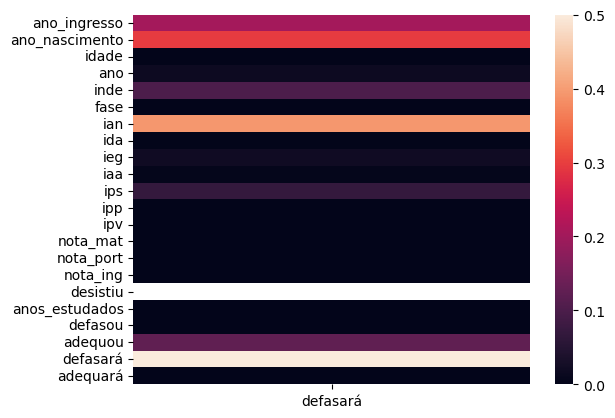

In [359]:
corr = df_long.corr(numeric_only=True)[['defasará']]

sns.heatmap(corr, vmin = 0, vmax = 0.5)

## Tratamento de dados para ML

In [360]:
df_ML = df_long.copy()

selection = df_ML['defasará'].isna() == False

df_ML = df_ML[selection]

#### Dados nulos

In [361]:
df_ML.isna().sum()

aluno                   0
ano_ingresso            0
ano_nascimento          0
genero                  0
idade                   0
ano                     0
inde                   75
fase                    0
pedra                  75
instituicao_ensino      0
ian                     0
ida                    72
ieg                    72
iaa                    59
ips                    62
ipp                    72
ipv                    72
nota_mat               72
nota_port              72
nota_ing              956
desistiu                0
anos_estudados          0
defasou               897
adequou               897
defasará                0
adequará                0
dtype: int64

##### Defasou / Adequou

In [362]:
df_ML.loc[df_ML['adequou'].isna(), 'adequou'] = 0
df_ML.loc[df_ML['defasou'].isna(), 'defasou'] = 0

##### Nota de inglês

In [363]:
english_mean = df_ML['nota_ing'].mean()
english_mean

np.float64(6.404889975550122)

In [364]:
select = df_ML['fase'] < 3
df_ML.loc[select, 'nota_ing'] = english_mean

#### Indicadores
Utilizaremos o KNNInputer para tentar preencher os indicadores que faltam

In [365]:
indicators = [
    'inde',
    'ian',
    'ida',
    'ieg',
    'iaa',
    'ips',
    'ipp',
    'ipv'
]

df_indicators = df_ML[indicators].copy()

df_indicators.describe()

,inde,ian,ida,ieg,iaa,ips,ipp,ipv
count,1290.000000,1365.000000,1293.000000,1293.000000,1306.000000,1303.000000,1293.000000,1293.000000
mean,7.365852,7.018315,6.659397,8.603094,7.660337,5.960775,7.009946,7.809000
std,0.876740,2.498466,1.693582,1.203474,2.986830,1.912407,1.239600,1.008848
min,3.700000,2.500000,1.000000,2.000000,0.000000,2.500000,2.810000,3.320000
25%,6.804000,5.000000,5.700000,8.100000,7.800000,5.000000,6.010000,7.250000
50%,7.455500,5.000000,6.900000,8.900000,8.800000,6.900000,7.187500,7.833000
75%,7.987185,10.000000,7.900000,9.500000,9.500000,7.500000,7.968750,8.450000
max,9.442000,10.000000,10.000000,10.000000,10.000000,10.000000,9.791667,10.000000


In [366]:
df_indicators.isna().sum()

inde    75
ian      0
ida     72
ieg     72
iaa     59
ips     62
ipp     72
ipv     72
dtype: int64

In [367]:
imputer = KNNImputer(n_neighbors = 3, missing_values = np.nan)
df_indicators_filled = pd.DataFrame(imputer.fit_transform(df_indicators))

df_indicators_filled.columns = df_indicators.columns

df_indicators_filled.isna().sum()

inde    0
ian     0
ida     0
ieg     0
iaa     0
ips     0
ipp     0
ipv     0
dtype: int64

In [368]:
display(df_indicators.describe())
display(df_indicators_filled.describe())

,inde,ian,ida,ieg,iaa,ips,ipp,ipv
count,1290.000000,1365.000000,1293.000000,1293.000000,1306.000000,1303.000000,1293.000000,1293.000000
mean,7.365852,7.018315,6.659397,8.603094,7.660337,5.960775,7.009946,7.809000
std,0.876740,2.498466,1.693582,1.203474,2.986830,1.912407,1.239600,1.008848
min,3.700000,2.500000,1.000000,2.000000,0.000000,2.500000,2.810000,3.320000
25%,6.804000,5.000000,5.700000,8.100000,7.800000,5.000000,6.010000,7.250000
50%,7.455500,5.000000,6.900000,8.900000,8.800000,6.900000,7.187500,7.833000
75%,7.987185,10.000000,7.900000,9.500000,9.500000,7.500000,7.968750,8.450000
max,9.442000,10.000000,10.000000,10.000000,10.000000,10.000000,9.791667,10.000000


,inde,ian,ida,ieg,iaa,ips,ipp,ipv
count,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000
mean,7.380140,7.018315,6.670965,8.639976,7.735653,5.942020,6.979477,7.835685
std,0.858118,2.498466,1.651125,1.185452,2.943073,1.873924,1.225785,0.989901
min,3.700000,2.500000,1.000000,2.000000,0.000000,2.500000,2.810000,3.320000
25%,6.837000,5.000000,5.700000,8.100000,7.900000,5.000000,6.043333,7.276667
50%,7.515233,5.000000,6.866667,9.000000,8.800000,6.300000,7.083333,7.875000
75%,7.964200,10.000000,7.800000,9.500000,9.500000,7.500000,7.968750,8.420000
max,9.442000,10.000000,10.000000,10.000000,10.000000,10.000000,9.791667,10.000000


In [369]:
# for col in df_indicators_filled.columns:
#     df_long[col] = df_indicators_filled[col]

In [370]:
df_long

,aluno,ano_ingresso,ano_nascimento,genero,idade,ano,inde,fase,pedra,instituicao_ensino,...,ipv,nota_mat,nota_port,nota_ing,desistiu,anos_estudados,defasou,adequou,defasará,adequará
0,Aluno-1,2016,2003,Feminino,19,2022,5.783000,7,Quartzo,Pública,...,7.2780,2.7,3.5,6.0,0.0,6,NaN,NaN,0.0,1.0
1,Aluno-2,2017,2005,Feminino,17,2022,7.055000,7,Ametista,Rede decisão,...,6.7780,6.3,4.5,9.7,0.0,5,NaN,NaN,0.0,0.0
2,Aluno-3,2016,2005,Feminino,17,2022,6.591000,7,Ágata,Rede decisão,...,7.5560,5.8,4.0,6.9,1.0,6,NaN,NaN,NaN,NaN
3,Aluno-4,2017,2005,Masculino,17,2022,5.951000,7,Quartzo,Rede decisão,...,5.2780,2.8,3.5,8.7,1.0,5,NaN,NaN,NaN,NaN
4,Aluno-5,2016,2005,Feminino,17,2022,7.427000,7,Ametista,Rede decisão,...,7.3890,7.0,2.9,5.7,0.0,6,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,Aluno-1657,2021,2004,Masculino,20,2024,NaN,9,NaN,Bolsista universitário *formado (a),...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1152,Aluno-1474,2024,2013,Feminino,11,2024,7.384208,2,Ametista,Pública,...,6.2875,7.0,8.0,NaN,NaN,0,NaN,NaN,NaN,NaN
1153,Aluno-1441,2024,2015,Masculino,9,2024,8.961646,1,Topázio,Pública,...,9.0050,9.0,8.0,NaN,NaN,0,NaN,NaN,NaN,NaN
1154,Aluno-1443,2024,2011,Feminino,13,2024,6.921633,1,Ágata,Pública,...,7.4150,6.5,7.0,NaN,NaN,0,NaN,NaN,NaN,NaN


## Escolha do modelo

In [371]:
SEED = 7234

#### Funções avaliadoras

In [372]:
def appraise_model(
        model,
        title,
        X_train : pd.DataFrame,
        y_train : pd.Series,
        X_test : pd.DataFrame,
        y_test : pd.Series
):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        average = (acc + prec + rec) / 3
        if title == "":
                txt = "="*10 + " RESULTS " + "="*10
        else: 
                txt = "="*10 + f" {title} " + "="*10
        print(f"\n{txt}")
        print(f"Accuracy\t\t{acc:.2f}")
        print(f"Precision\t\t{prec:.2f}")
        print(f"Recall\t\t\t{rec:.2f}")
        print()
        print(f'Average\t\t{average:.2f}')

        return model

#### Base de treino

In [373]:
features = [
    'ano_ingresso',
    'idade',
    'inde',
    'fase',
    'ian',
    'adequou'
]

target = 'defasará'

In [374]:
X = df_ML[features]
y = df_ML[target]

In [375]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=SEED)

In [376]:
y_train.value_counts()

defasará
0.0    973
1.0    119
Name: count, dtype: int64

#### Modelos

In [377]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [378]:
model_LR = appraise_model(LogisticRegression(), "LogisticRegression", X_train, y_train, X_test, y_test)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Deploy Streamlit